# **Fatores para o Desenvolvimento**

#### Utilizando o aprendizado de máquina nas Ciências Sociais

### Introdução

#### O que faz um país ser desenvolvido? Ao longo dos anos, diversos organismos nacionais e internacionais desenvolveram métricas para medir diversos aspectos econômicos e sociais que em conjunto permitem ter uma visão dos diversos fatores que contribuem para o desenvolvimento.

#### Normalmente, cada métrica é medida separadamente das demais e analisada por uma pessoa que então tira conclusões sobre o impacto desta métrica no nível de desenvolvimento de um determinado país. Nas pesquisas iniciais para o trabalho, não foram identificados outros  trabalhos que levassem em conta alguma análise de fatores simultâneos nem o uso de técnicas de aprendizado de máquina.

#### No presente trabalho, serão utilizadas técnicas de aprendizado de máquinas, visando conjugar várias métricas indicativas do grau de desenvolvimento em um único modelo para classificar os países entre desenvolvidos e não desenvolvidos. Como fonte primordial  são os dados levantados e compilados pela publicação científica online OurWorldInData, que é um esforço conjugado da Universidade de Oxford e da ONG Global Change Data Lab. Os dados são compilados de diversas fontes, notadamente de órgãos oficiais como por exemplo ONU, FMI, Banco Mundial, entre outros.



### Inclusão das bibliotecas

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns #visualisation
import matplotlib.pyplot as plt #visualisation

### Carga dos datasets das features

In [2]:
fertility = pd.read_csv("children-born-per-woman.csv")
ch_mortality = pd.read_csv("child-mortality-igme.csv")
literacy = pd.read_csv("cross-country-literacy-rates.csv")
gini = pd.read_csv("economic-inequality-gini-index.csv")
energy_use = pd.read_csv("energy-use-per-capita.csv")
gdp_per_capita = pd.read_csv("gdp-per-capita-worldbank.csv")
gov_exp = pd.read_csv("historical-gov-spending-gdp.csv")
human_rights = pd.read_csv("human-rights-scores.csv")
life_expectancy = pd.read_csv("life-expectancy.csv")
avg_years_school = pd.read_csv("mean-years-of-schooling-long-run.csv")
political_regime = pd.read_csv("political-regime-updated2016.csv")
population = pd.read_csv("population.csv")
internet = pd.read_csv("share-of-individuals-using-the-internet.csv")
sanitation = pd.read_csv("share-of-population-with-improved-sanitation-faciltities.csv")
extreme_poverty = pd.read_csv("share-of-the-population-living-in-extreme-poverty.csv")
electricity = pd.read_csv("share-of-the-population-with-access-to-electricity.csv")
water = pd.read_csv("share-of-the-population-with-access-to-improved-drinking-water.csv")
subnutrition = pd.read_csv("share-undernourished-2000-2017.csv")
corruption = pd.read_csv("TI-corruption-perception-index.csv")
taxes = pd.read_csv("total-tax-revenues-gdp.csv")
developed = pd.read_csv("advanced-economies-IMF.csv")

In [3]:
developed.set_index('Entity', inplace=True)

### Filtragem dos datasets

In [5]:
fertility = fertility.query('Year <= 2019 and Entity!="World"').groupby("Entity").last().loc[:,['Fertility']]
ch_mortality = ch_mortality.query('Year <= 2019 and Entity!="World"').groupby("Entity").last().loc[:,['Ch_mortality']]
literacy = literacy.query('Year <= 2019 and Entity!="World"').groupby("Entity").last().loc[:,['Literacy']]
gini = gini.query('Year <= 2019 and Entity!="World"').groupby("Entity").last().loc[:,['Gini']]
energy_use = energy_use.query('Year <= 2019 and Entity!="World"').groupby("Entity").last().loc[:,['Energy_use']]
gdp_per_capita = gdp_per_capita.query('Year <= 2019 and Entity!="World"').groupby("Entity").last().loc[:,['Gdp_per_capita']]
gov_exp = gov_exp.query('Year <= 2019 and Entity!="World"').groupby("Entity").last().loc[:,['Gov_exp']]
human_rights = human_rights.query('Year <= 2019 and Entity!="World"').groupby("Entity").last().loc[:,['Human_rights']]
life_expectancy = life_expectancy.query('Year <= 2019 and Entity!="World"').groupby("Entity").last().loc[:,['Life_expectancy']]
avg_years_school = avg_years_school.query('Year <= 2019 and Entity!="World"').groupby("Entity").last().loc[:,['Avg_years_school']]
political_regime = political_regime.query('Year <= 2019 and Entity!="World"').groupby("Entity").last().loc[:,['Political_regime']]
population = population.query('Year <= 2019 and Entity!="World"').groupby("Entity").last().loc[:,['Population']]
internet = internet.query('Year <= 2019 and Entity!="World"').groupby("Entity").last().loc[:,['Internet']]
sanitation = sanitation.query('Year <= 2019 and Entity!="World"').groupby("Entity").last().loc[:,['Sanitation']]
extreme_poverty = extreme_poverty.query('Year <= 2019 and Entity!="World"').groupby("Entity").last().loc[:,['Extreme_poverty']]
electricity = electricity.query('Year <= 2019 and Entity!="World"').groupby("Entity").last().loc[:,['Electricity']]
water = water.query('Year <= 2019 and Entity!="World"').groupby("Entity").last().loc[:,['Water']]
subnutrition = subnutrition.query('Year <= 2019 and Entity!="World"').groupby("Entity").last().loc[:,['Subnutrition']]
corruption = corruption.query('Year <= 2019 and Entity!="World"').groupby("Entity").last().loc[:,['Corruption']]
taxes = taxes.query('Year <= 2019 and Entity!="World"').groupby("Entity").last().loc[:,['Taxes']]

In [8]:
devfacts = population.join([fertility, ch_mortality, literacy, gini, energy_use, gov_exp, human_rights, life_expectancy, avg_years_school, political_regime, gdp_per_capita, internet, sanitation, extreme_poverty, electricity, water, subnutrition, corruption, taxes], how='outer', sort=False)

In [9]:
#devfacts=devfacts.fillna(value=0)
devfacts=devfacts.query("Population>=200000 & index  not in ['Oceania','Asia', 'Africa', 'Western Sahara','Europe','North America','Latin America']")

### Imputação (método de imputação interativa)

In [10]:
# To use this experimental feature, we need to explicitly ask for it:
from sklearn.experimental import enable_iterative_imputer  # noqa
from sklearn.impute import IterativeImputer
from sklearn.ensemble import ExtraTreesRegressor

est = ExtraTreesRegressor(n_estimators=10, random_state=0)
devimputer = IterativeImputer(estimator=est, verbose=1, random_state=0)
devimputed = devimputer.fit_transform(devfacts)

[IterativeImputer] Completing matrix with shape (186, 20)
[IterativeImputer] Change: 41666.812010542664, scaled tolerance: 1433784.064 
[IterativeImputer] Early stopping criterion reached.


In [11]:
devfacts2 = pd.DataFrame(data=devimputed, index=devfacts.index, columns=devfacts.columns)

### Dataset antes da imputação

In [12]:
devfacts.head(10)

,Population,Fertility,Ch_mortality,Literacy,Gini,Energy_use,Gov_exp,Human_rights,Life_expectancy,Avg_years_school,Political_regime,Gdp_per_capita,Internet,Sanitation,Extreme_poverty,Electricity,Water,Subnutrition,Corruption,Taxes
Afghanistan,38042000.0,4.18,6.79,38.168041,NaN,NaN,22.986809,-2.311017,64.833,3.8,-1.0,1803.987487,10.595726,31.9,NaN,84.137138,55.3,30.3,16.0,9.506653
Albania,2881000.0,1.70,0.88,97.553902,29.0,9402.341415,31.650253,0.851180,78.573,10.0,9.0,11803.430594,66.363445,93.2,1.1,100.000000,95.1,5.5,36.0,23.525330
Algeria,43053000.0,2.59,2.40,79.608398,27.6,15364.387111,40.681458,0.354197,76.880,8.0,2.0,13913.839363,42.945527,87.6,0.5,99.439568,83.6,4.7,35.0,14.321747
Angola,31825000.0,5.48,8.11,71.164162,42.7,6338.820907,39.555578,-0.388863,61.147,5.1,-2.0,5819.494971,13.000000,51.6,30.1,40.520607,49.0,23.9,19.0,16.626938
Argentina,44781000.0,2.25,1.04,98.089973,42.7,23436.625279,43.265590,0.784109,76.667,9.9,9.0,18933.907147,70.968981,96.4,0.6,100.000000,99.1,3.8,40.0,30.086376
Armenia,2958000.0,1.59,1.26,99.768417,32.4,11840.168525,25.907229,0.106262,75.087,11.7,5.0,8787.579940,64.346030,89.5,1.8,100.000000,100.0,4.3,35.0,21.244073
Australia,25203000.0,1.82,0.35,99.000000,34.7,63683.759273,36.743112,1.753645,83.436,12.9,10.0,44648.709911,86.544721,100.0,0.5,100.000000,100.0,NaN,77.0,28.578520
Austria,8955000.0,1.53,0.36,98.000000,30.5,44197.482259,52.710510,2.275799,81.544,12.1,10.0,45436.685822,87.935587,100.0,0.7,100.000000,100.0,NaN,76.0,41.750322
Azerbaijan,10048000.0,2.02,2.30,99.805260,31.8,17469.169099,34.645424,-0.397757,73.005,10.7,-7.0,15847.418833,79.000000,89.3,0.0,100.000000,87.0,2.5,25.0,16.506068
Bahamas,389000.0,1.74,0.72,95.599998,NaN,24087.045173,NaN,0.844840,73.918,11.1,NaN,27717.847298,80.000000,92.0,NaN,100.000000,98.4,NaN,65.0,15.101101


### Dataset após a imputação

In [13]:
devfacts2.head(10)

,Population,Fertility,Ch_mortality,Literacy,Gini,Energy_use,Gov_exp,Human_rights,Life_expectancy,Avg_years_school,Political_regime,Gdp_per_capita,Internet,Sanitation,Extreme_poverty,Electricity,Water,Subnutrition,Corruption,Taxes
Afghanistan,38042000.0,4.18,6.79,38.168041,35.34,4006.020683,22.986809,-2.311017,64.833,3.8,-1.0,1803.987487,10.595726,31.9,22.46,84.137138,55.3,30.30,16.0,9.506653
Albania,2881000.0,1.70,0.88,97.553902,29.00,9402.341415,31.650253,0.851180,78.573,10.0,9.0,11803.430594,66.363445,93.2,1.10,100.000000,95.1,5.50,36.0,23.525330
Algeria,43053000.0,2.59,2.40,79.608398,27.60,15364.387111,40.681458,0.354197,76.880,8.0,2.0,13913.839363,42.945527,87.6,0.50,99.439568,83.6,4.70,35.0,14.321747
Angola,31825000.0,5.48,8.11,71.164162,42.70,6338.820907,39.555578,-0.388863,61.147,5.1,-2.0,5819.494971,13.000000,51.6,30.10,40.520607,49.0,23.90,19.0,16.626938
Argentina,44781000.0,2.25,1.04,98.089973,42.70,23436.625279,43.265590,0.784109,76.667,9.9,9.0,18933.907147,70.968981,96.4,0.60,100.000000,99.1,3.80,40.0,30.086376
Armenia,2958000.0,1.59,1.26,99.768417,32.40,11840.168525,25.907229,0.106262,75.087,11.7,5.0,8787.579940,64.346030,89.5,1.80,100.000000,100.0,4.30,35.0,21.244073
Australia,25203000.0,1.82,0.35,99.000000,34.70,63683.759273,36.743112,1.753645,83.436,12.9,10.0,44648.709911,86.544721,100.0,0.50,100.000000,100.0,3.26,77.0,28.578520
Austria,8955000.0,1.53,0.36,98.000000,30.50,44197.482259,52.710510,2.275799,81.544,12.1,10.0,45436.685822,87.935587,100.0,0.70,100.000000,100.0,4.12,76.0,41.750322
Azerbaijan,10048000.0,2.02,2.30,99.805260,31.80,17469.169099,34.645424,-0.397757,73.005,10.7,-7.0,15847.418833,79.000000,89.3,0.00,100.000000,87.0,2.50,25.0,16.506068
Bahamas,389000.0,1.74,0.72,95.599998,41.37,24087.045173,27.195967,0.844840,73.918,11.1,5.6,27717.847298,80.000000,92.0,1.16,100.000000,98.4,5.00,65.0,15.101101


### Matriz de correlação (Mapa de calor)

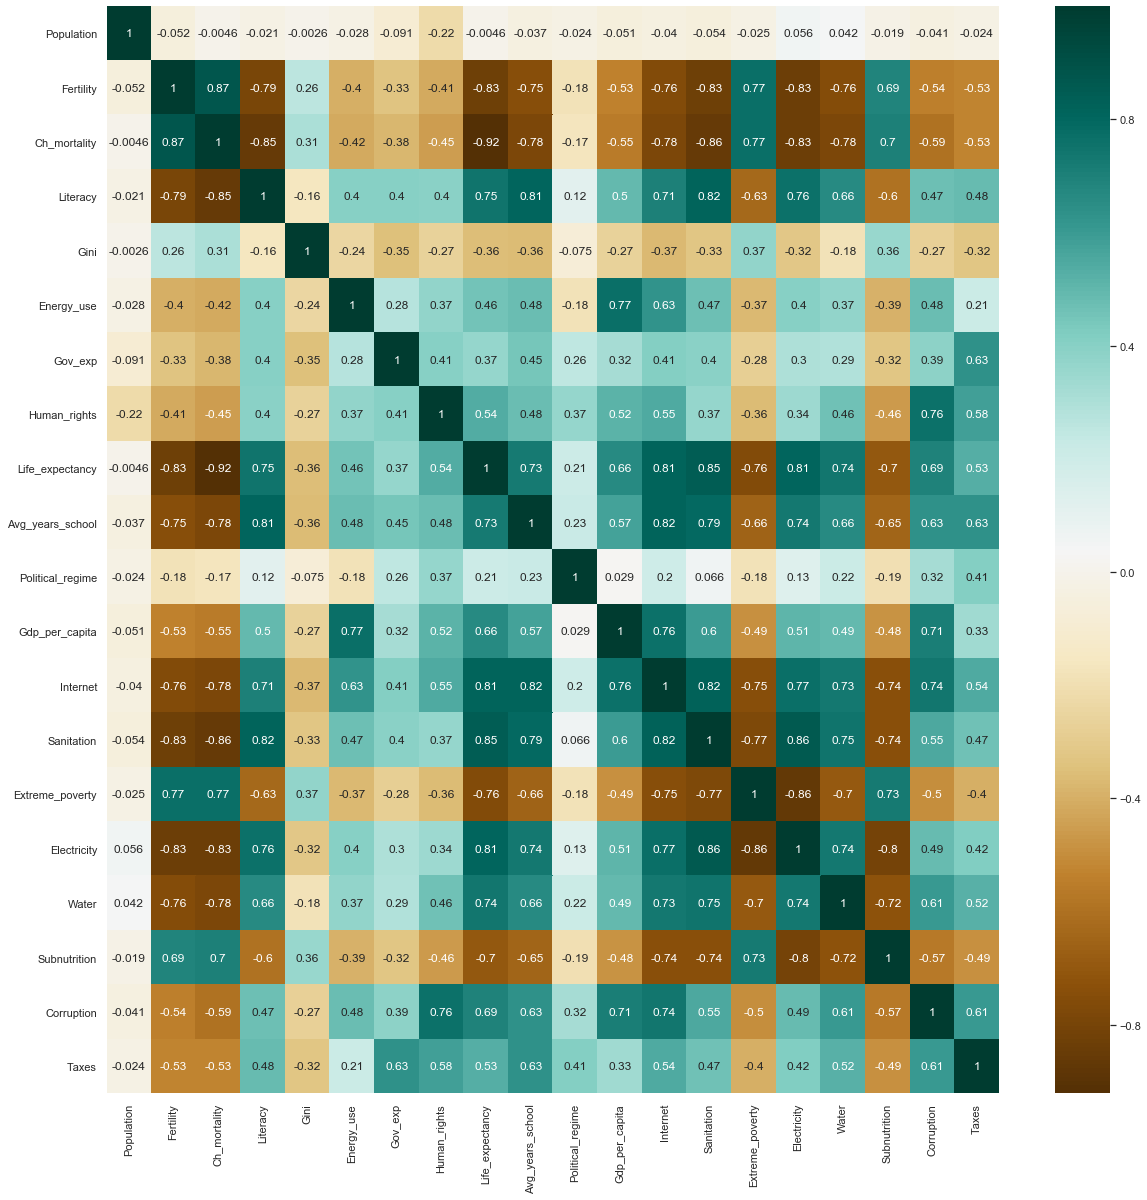

In [14]:
%matplotlib inline
sns.set(color_codes=True)
plt.figure(figsize=(20,20))
c= devfacts2.corr()
sns.heatmap(c,cmap='BrBG',annot=True)

### Matriz de correlação sem a feature população ( Mapa de Calor)

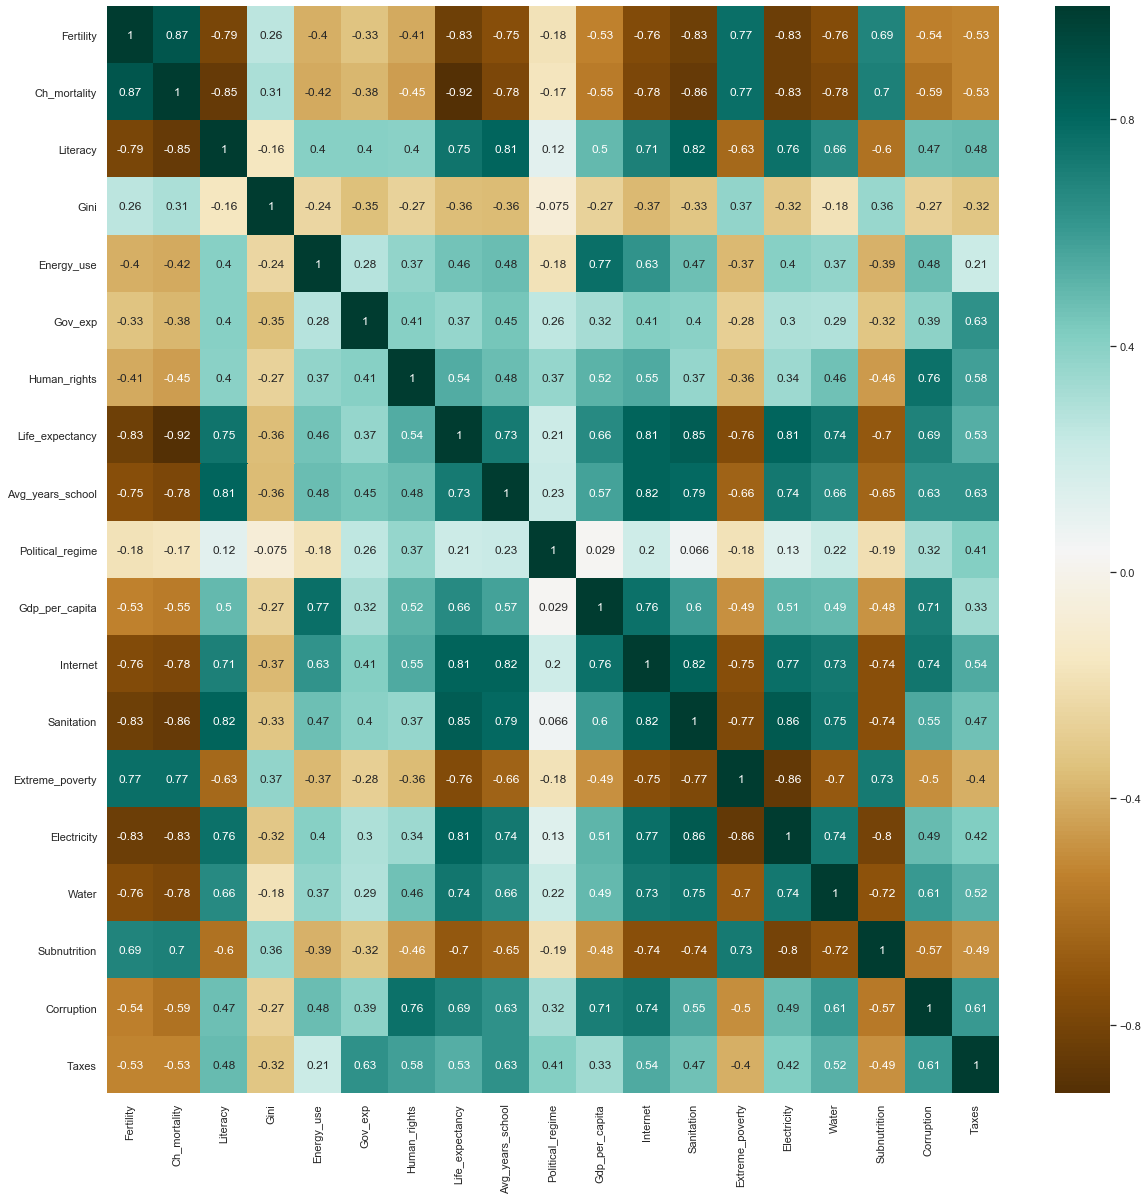

In [15]:
plt.figure(figsize=(20,20))
devfacts2_pop = devfacts2
devfacts2.drop('Population' , axis='columns', inplace=True)
c= devfacts2.corr()
sns.heatmap(c,cmap='BrBG',annot=True)

### Validação cruzada do modelo de árvore de decisão

In [16]:
target = devfacts2.join(developed, how='left', sort=False).loc[:,['Developed']]
target.fillna(-1, inplace=True)
target = target.astype(dtype={'Developed' : int})

In [59]:
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier

devtree =DecisionTreeClassifier( min_samples_split=5, random_state=0)
scores_pop = cross_val_score(devtree, devfacts2_pop, target.values.ravel(),scoring='accuracy', cv=5)
scores = cross_val_score(devtree, devfacts2, target.values.ravel(), scoring='accuracy', cv=5)
scores_pop, scores 

(array([0.97368421, 0.97297297, 0.97297297, 0.91891892, 0.97297297]),
 array([0.97368421, 0.97297297, 0.97297297, 0.91891892, 0.97297297]))

### Criação do modelo de Árvore de Decisão e plotagem da árvore

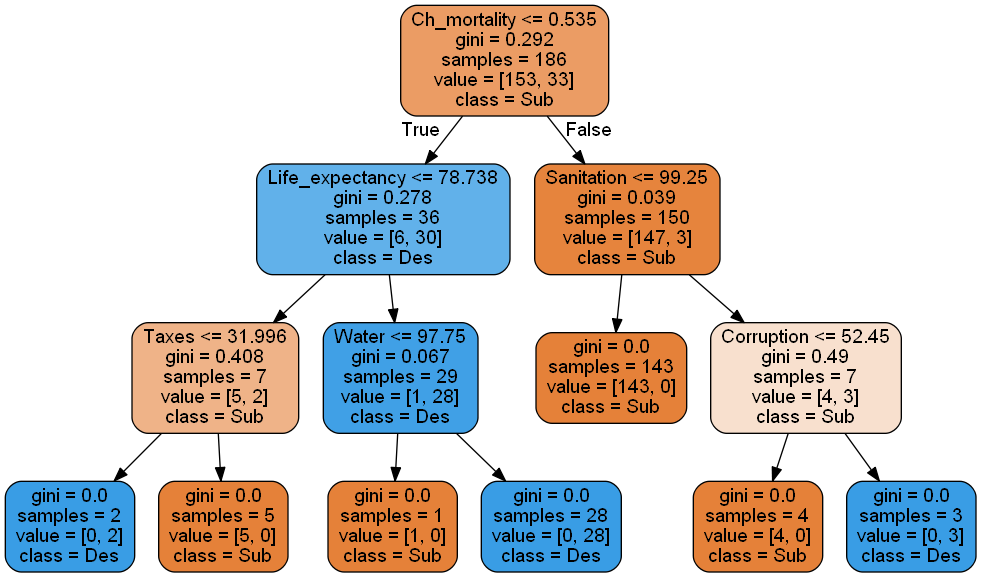

In [19]:
import pydotplus
from IPython.display import Image  
from sklearn.tree import DecisionTreeClassifier, export_graphviz

# class labels
labels = devfacts2.columns

devtree = DecisionTreeClassifier( min_samples_split=5, random_state=0)
devtree.fit(devfacts2, target)

dot_data = export_graphviz(devtree, out_file=None,  feature_names=labels, class_names=['Sub','Des'], rounded=True, filled=True)

Image(pydotplus.graph_from_dot_data(dot_data).create_png())

### Correlação das principais features apontadas pela árvore de decisão

In [20]:
dataset = devfacts2.join(developed, how='left', sort=False)
dataset.fillna(-1, inplace=True)
dataset = dataset.astype(dtype={'Developed' : int})

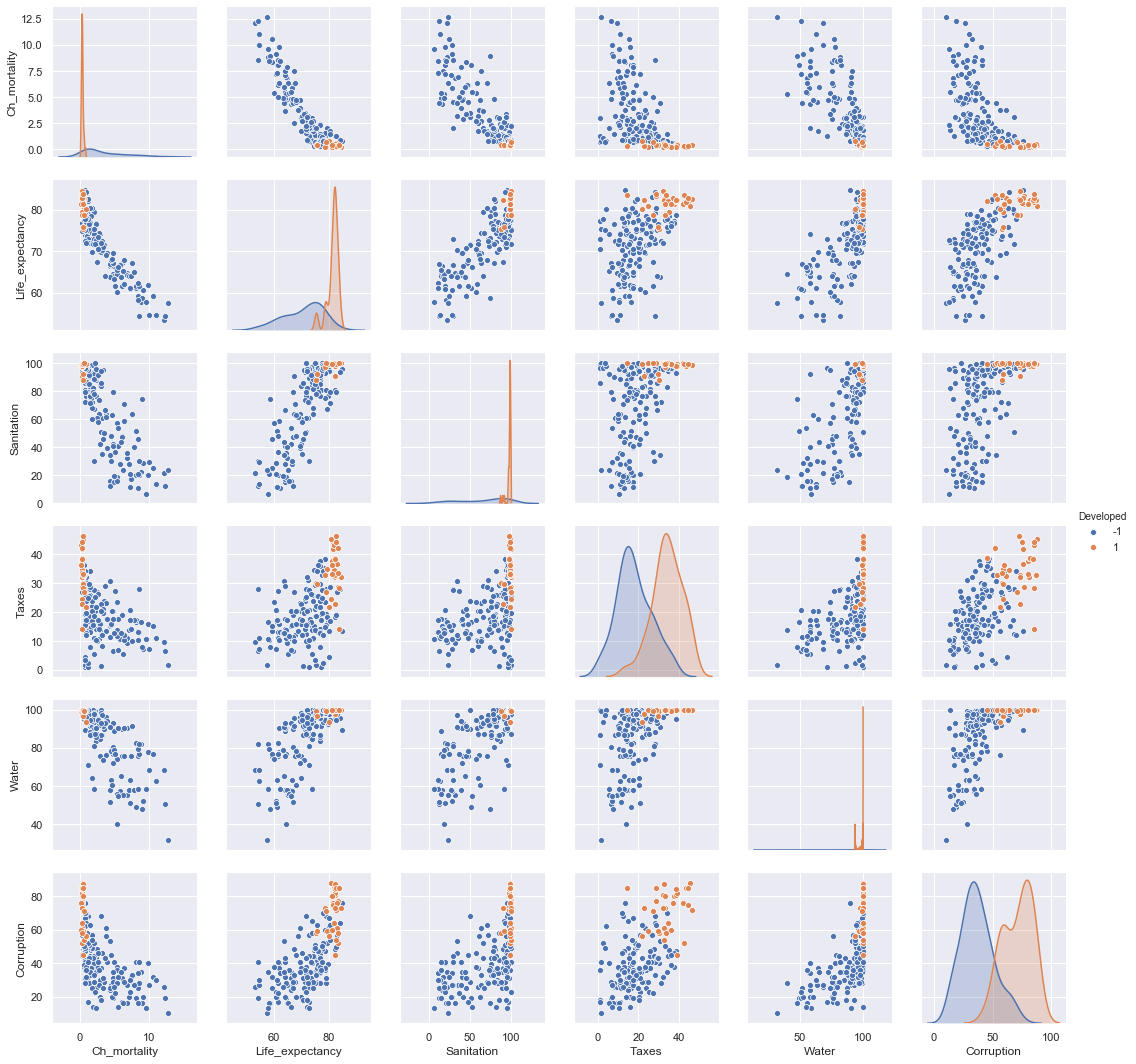

In [21]:
sns.pairplot(dataset, vars = ["Ch_mortality", "Life_expectancy", "Sanitation", "Taxes", "Water","Corruption"], hue = 'Developed')

### Criação do modelo de Cluster Hierárquico Aglomerativo e plotagem do dendrograma 

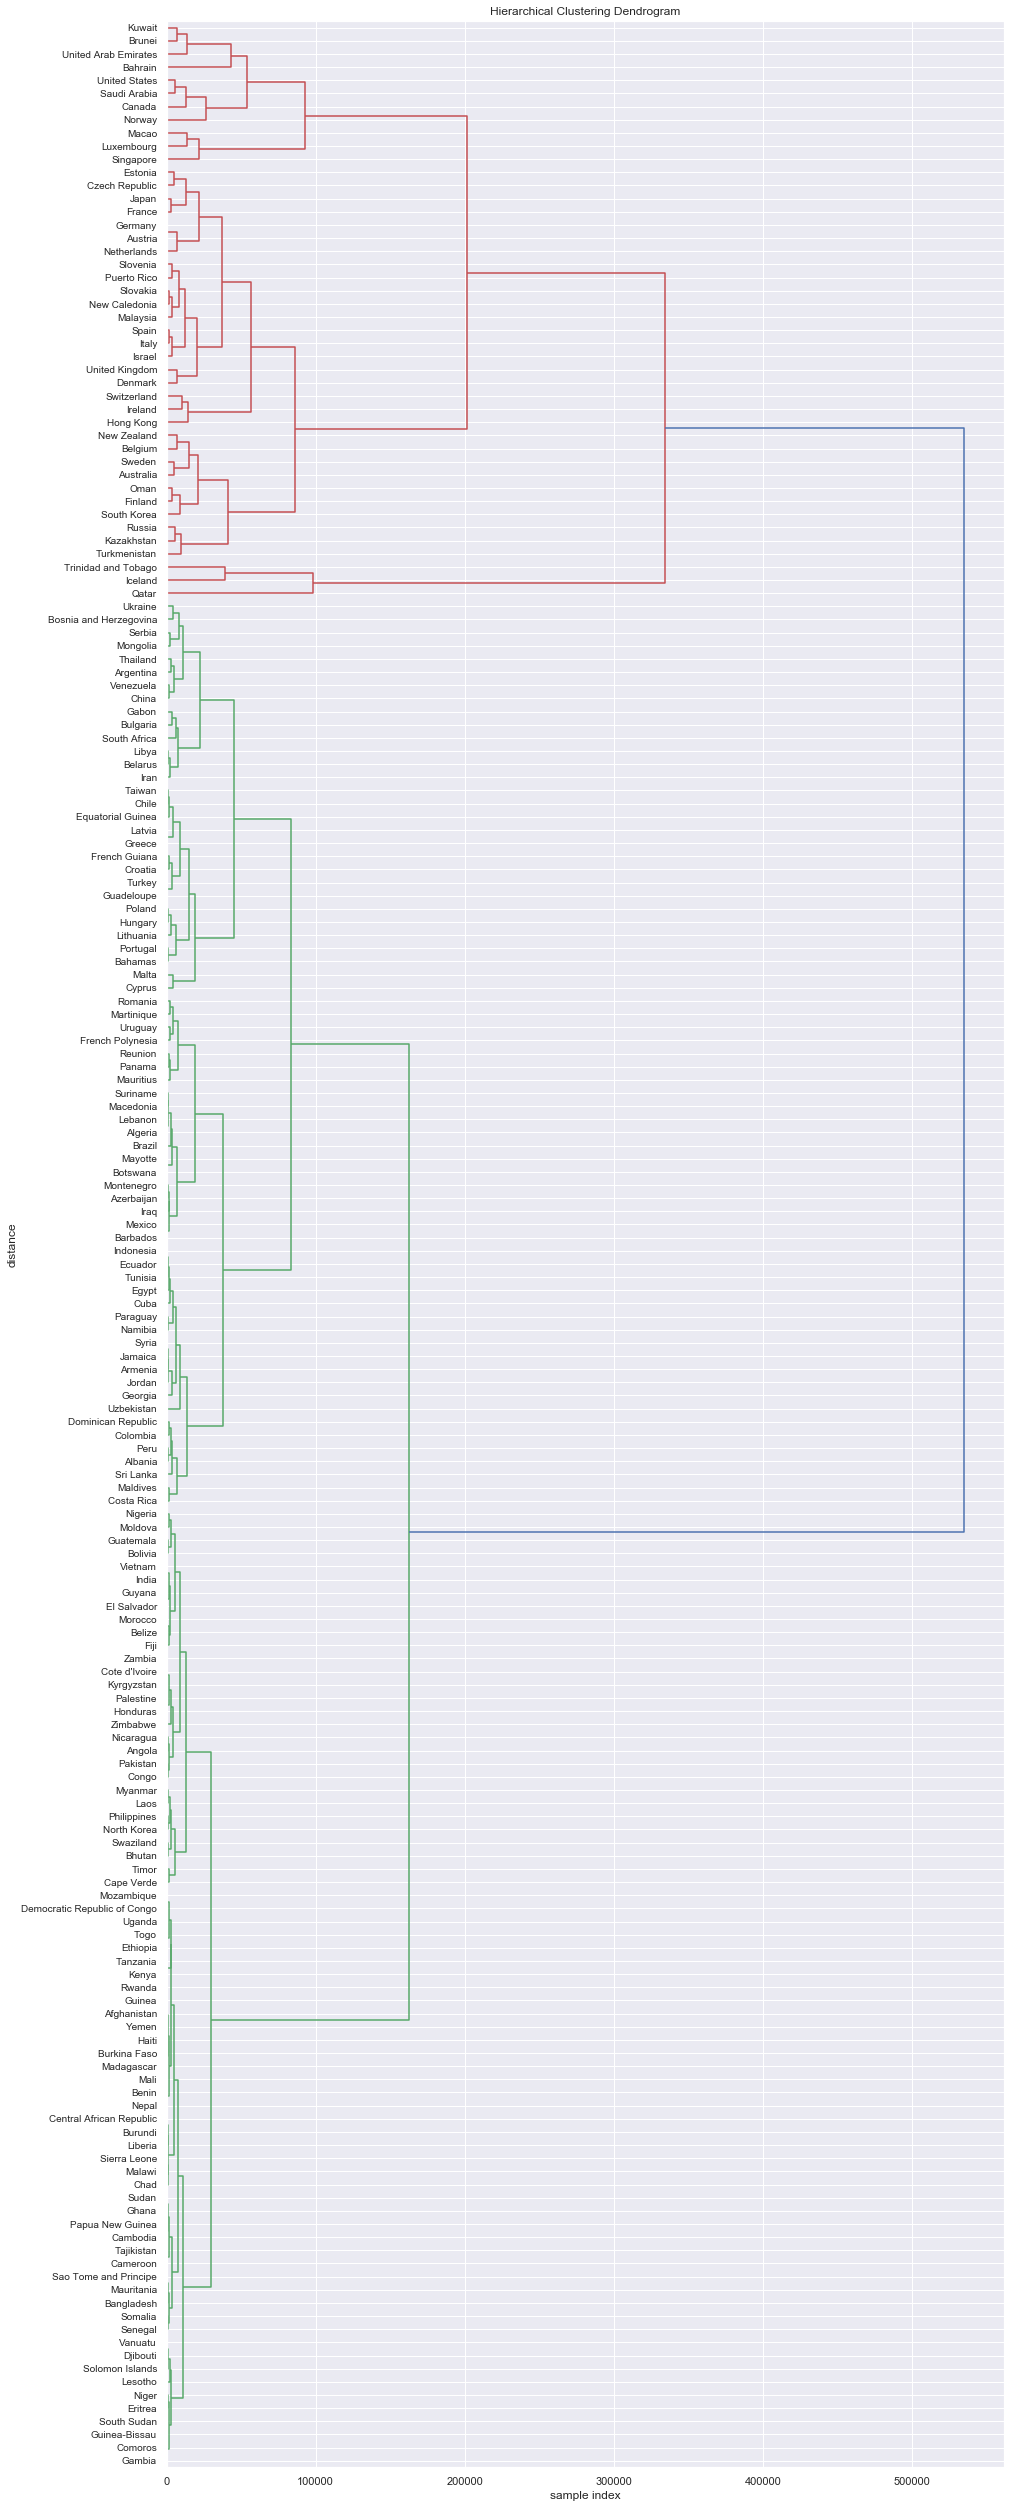

In [22]:
from scipy.cluster.hierarchy import dendrogram, linkage, leaves_list

Z = linkage(devfacts2.to_numpy() , 'ward')
plt.figure(figsize=(15, 45))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('sample index')
plt.ylabel('distance')
R = dendrogram(
    Z,
    leaf_font_size=10.,  # font size for the x axis labels
    orientation='right',
    labels=devfacts2.index.to_list())
plt.savefig('devfacts_dendrogram.png',bbox_inches='tight',pad_inches=0.5)
plt.show()



### Predição de países desenvolvidos e subdesenvolvidos - Árvore de Decisão

In [25]:
devclas=devtree.predict(devfacts2)
sub = []
dev = []
for i, v in enumerate(devclas.tolist()):
    if v==-1:
        sub.append(devfacts2.index[i])
    else:
        dev.append(devfacts2.index[i])
supsub = ', '.join(sub)
supdev = ', '.join(dev)
supsub, supdev

("Afghanistan, Albania, Algeria, Angola, Argentina, Armenia, Azerbaijan, Bahamas, Bahrain, Bangladesh, Barbados, Belarus, Belize, Benin, Bhutan, Bolivia, Bosnia and Herzegovina, Botswana, Brazil, Brunei, Bulgaria, Burkina Faso, Burundi, Cambodia, Cameroon, Cape Verde, Central African Republic, Chad, Chile, China, Colombia, Comoros, Congo, Costa Rica, Cote d'Ivoire, Croatia, Cuba, Democratic Republic of Congo, Djibouti, Dominican Republic, Ecuador, Egypt, El Salvador, Equatorial Guinea, Eritrea, Ethiopia, Fiji, French Guiana, French Polynesia, Gabon, Gambia, Georgia, Ghana, Guadeloupe, Guatemala, Guinea, Guinea-Bissau, Guyana, Haiti, Honduras, Hong Kong, Hungary, India, Indonesia, Iran, Iraq, Jamaica, Jordan, Kazakhstan, Kenya, Kuwait, Kyrgyzstan, Laos, Lebanon, Lesotho, Liberia, Libya, Macao, Macedonia, Madagascar, Malawi, Malaysia, Maldives, Mali, Martinique, Mauritania, Mauritius, Mayotte, Mexico, Moldova, Mongolia, Montenegro, Morocco, Mozambique, Myanmar, Namibia, Nepal, New Caledo

### Predição de países desenvolvidos e subdesenvolvidos - Cluster Hierárquico Aglomerativo

In [52]:
# A variável R é um dicionário retornado pela função dendrogram(). Ele contém a entrada color_list que traz a lista 
# de cores de cada país que aparece no dendrograma na ordem em que eles aparecem e a entrada ivl que lista os países
# na ordem que eles aparecem no dendrograma. Portanto a i-ésima cor corresponde ao i-ésimo país e como a cor vermelha
# foi utilizada para os países desenvolvidos e a cor verde para os paises subdesenvolvidos, ao separarmos os países
# por cor estaremos separando entre desenvolvidos e subdesenvolvidos

cl = R['color_list']
l = R['ivl']
sub_uns = []
dev_uns = []
for i in range(len(cl)):
    if cl[i]=='g':
        sub_uns.append(l[i])
    elif cl[i]=='r':
        dev_uns.append(l[i])
sub_uns.sort()
dev_uns.sort()
unssub = ', '.join(sub_uns)
unsdev = ', '.join(dev_uns)
unssub,unsdev

("Afghanistan, Albania, Algeria, Angola, Argentina, Armenia, Azerbaijan, Bahamas, Bangladesh, Barbados, Belarus, Belize, Benin, Bhutan, Bolivia, Bosnia and Herzegovina, Botswana, Brazil, Bulgaria, Burkina Faso, Burundi, Cambodia, Cameroon, Cape Verde, Central African Republic, Chad, Chile, China, Colombia, Comoros, Congo, Costa Rica, Cote d'Ivoire, Croatia, Cuba, Cyprus, Democratic Republic of Congo, Djibouti, Dominican Republic, Ecuador, Egypt, El Salvador, Equatorial Guinea, Eritrea, Ethiopia, Fiji, French Guiana, French Polynesia, Gabon, Gambia, Georgia, Ghana, Greece, Guadeloupe, Guatemala, Guinea, Guinea-Bissau, Guyana, Haiti, Honduras, Hungary, India, Indonesia, Iran, Iraq, Jamaica, Jordan, Kenya, Kyrgyzstan, Laos, Latvia, Lebanon, Lesotho, Liberia, Libya, Lithuania, Macedonia, Madagascar, Malawi, Maldives, Mali, Malta, Martinique, Mauritania, Mauritius, Mayotte, Mexico, Moldova, Mongolia, Montenegro, Morocco, Mozambique, Myanmar, Namibia, Nepal, Nicaragua, Niger, Nigeria, North 

### Comparação das classificações  - Árvore de Decisão X Cluster Hierárquico Aglomerativo

In [53]:
# países desenvolvidos
dev_tree = set(dev)
dev_clus = set(dev_uns)
# países desenvolvidos segundo a árvore e subdesenvolvidos segundo cluster
dev_tree_minus_clus = dev_tree - dev_clus
# países desenvolvidos segundo o cluster e subdesenvolvidos segundo ávore
dev_clus_minus_tree = dev_clus - dev_tree

# países subdesenvolvidos
sub_tree = set(sub)
sub_clus = set(sub_uns)
# países subdesenvolvidos segundo a árvore e desenvolvidos segundo cluster
sub_tree_minus_clus = sub_tree - sub_clus
# países subdesenvolvidos segundo o cluster e desenvolvidos segundo ávore
sub_clus_minus_tree = sub_clus - sub_tree

dev_tree_minus_clus, dev_clus_minus_tree, sub_tree_minus_clus, sub_clus_minus_tree

({'Brunei', 'Cyprus', 'Greece', 'Latvia', 'Lithuania', 'Malta', 'Portugal'},
 set(),
 {'Bahrain',
  'Brunei',
  'Hong Kong',
  'Kazakhstan',
  'Kuwait',
  'Macao',
  'Malaysia',
  'New Caledonia',
  'Oman',
  'Qatar',
  'Russia',
  'Saudi Arabia',
  'Slovakia',
  'South Korea',
  'Trinidad and Tobago',
  'Turkmenistan',
  'Ukraine',
  'United Arab Emirates'},
 set())